In [327]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [328]:
gwind = pd.read_csv('germany-wind-energy.csv')

In [329]:
gwind.tail()

,utc_timestamp,wind_generation_actual,wind_capacity,temperature
1089,2019-12-26 00:00:00+00:00,132739,50424.125,2.790
1090,2019-12-27 00:00:00+00:00,146590,50427.000,1.327
1091,2019-12-28 00:00:00+00:00,159126,50427.292,-1.441
1092,2019-12-29 00:00:00+00:00,349839,50434.750,-1.314
1093,2019-12-30 00:00:00+00:00,254333,50452.000,0.542


In [330]:
gwind.isnull().sum()

utc_timestamp             0
wind_generation_actual    0
wind_capacity             0
temperature               0
dtype: int64

### Checking for Seasonalities

In [331]:
import statsmodels.api as sm

def decompose_df(df, share_type, samples=250, period=7):
    if samples == 'all':
        #decomposing all time series timestamps
        res = sm.tsa.seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = sm.tsa.seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16, 8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series 
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality. Period = 24*7 weekly seasonality
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(trend)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

#### For the Last Updated Time Statistics of COVID-19 in 2020

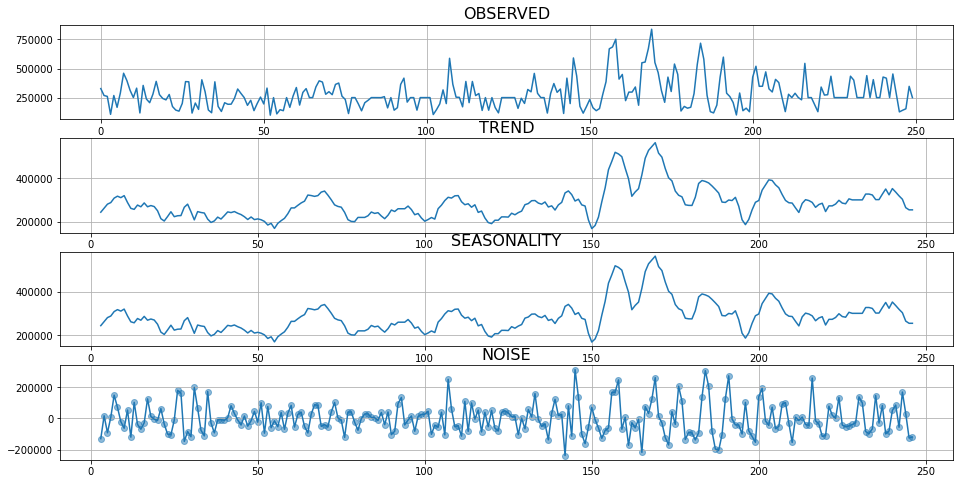

In [332]:
decompose_df(gwind, 'wind_generation_actual')

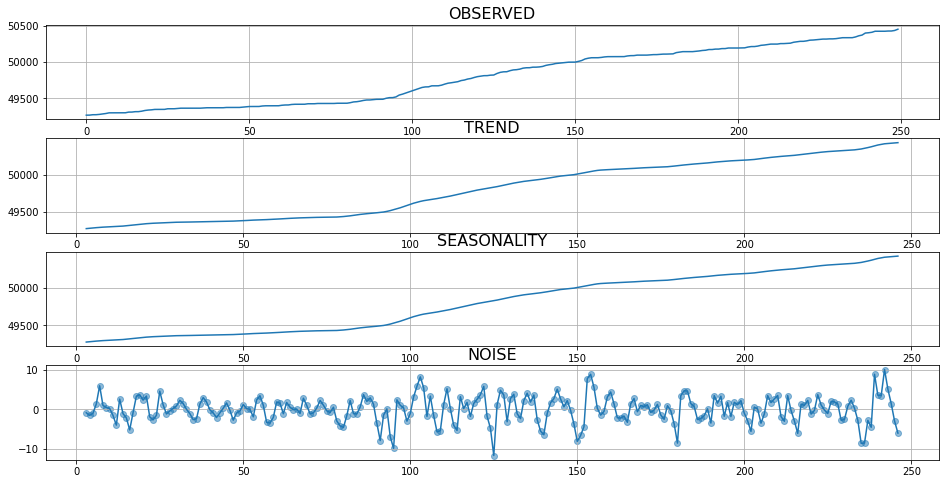

In [333]:
decompose_df(gwind, 'wind_capacity')

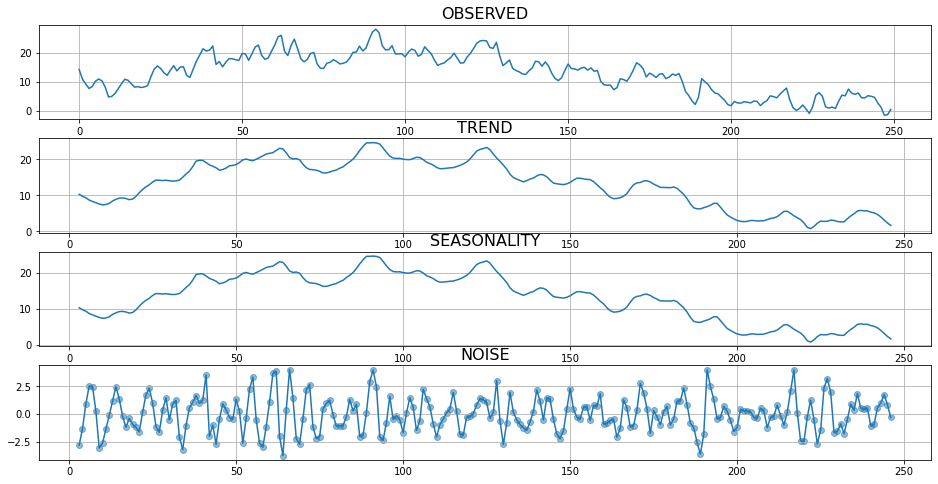

In [334]:
decompose_df(gwind, 'temperature')

### FIND IF THE MODEL IS AUTOREGRESSIVE OR NOT

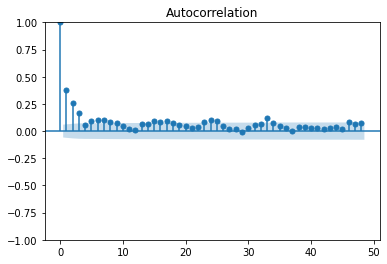

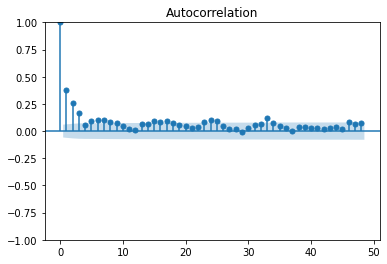

In [335]:
from statsmodels.graphics.tsaplots import plot_acf

#With 48 lags
plot_acf(gwind['wind_generation_actual'].values, lags=48)

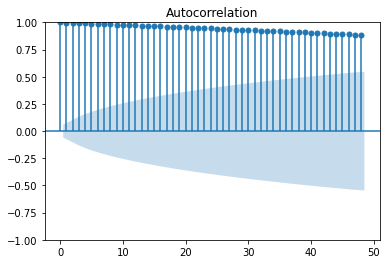

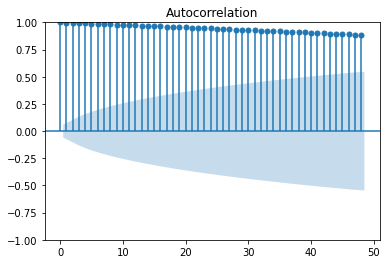

In [336]:
plot_acf(gwind['wind_capacity'].values, lags=48)

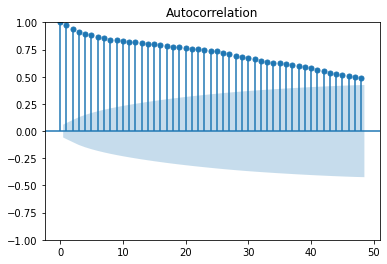

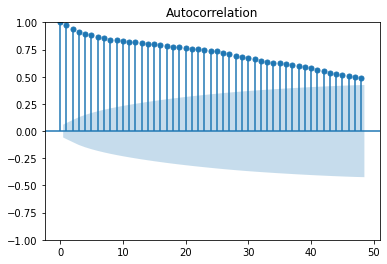

In [337]:
plot_acf(gwind['temperature'].values, lags=48)

In [338]:
#convert datetime fro, object to datetime type
gwind['utc_timestamp'] = pd.to_datetime(gwind['utc_timestamp'])

#set datetime as index
gwind = gwind.set_index(gwind.utc_timestamp)

#create hour, day and month variables from datetime index
gwind["year"] = gwind.index.year
gwind["month"] = gwind.index.month
gwind["day"] = gwind.index.day

#drop datetime column
gwind.drop('utc_timestamp', axis=1, inplace=True)

In [339]:
from lightgbm import LGBMRegressor

def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred)/actual))*100

def train_time_series_with_folds(df, horizon = 7*60):
    X = df.drop('wind_generation_actual', axis=1)
    y = df['wind_generation_actual']
    
    #take last week of the dataset for validation
    X_train, X_test = X.iloc[:-horizon,:], X.iloc[-horizon:,:]
    y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
    
    #create, train and derive inferences of the model
    model = LGBMRegressor(random_state = 42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    #calculate MAE
    mean_absolute_percentage_error = np.round(mape(y_test, predictions), 3)
    
    #plot reality vs prediction for the last week of the dataset
    fig = plt.figure(figsize=(16, 8))
    plt.title(f'Real vs Prediction - MAPE {mean_absolute_percentage_error}', fontsize=20)
    plt.plot(y_test, color='red')
    plt.plot(pd.Series(predictions, index=y_test.index), color='green')
    plt.xlabel('Month', fontsize=16)
    plt.ylabel('Amount of energy generated by windmills', fontsize=16)
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({'feature': model.feature_name_, 'importance': model.feature_importances_}).sort_values(by='importance', ascending=False)
    
    #plot variable of the model
    plt.title('Variable Importances', fontsize=16)
    sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
    plt.show()

### Without Lags

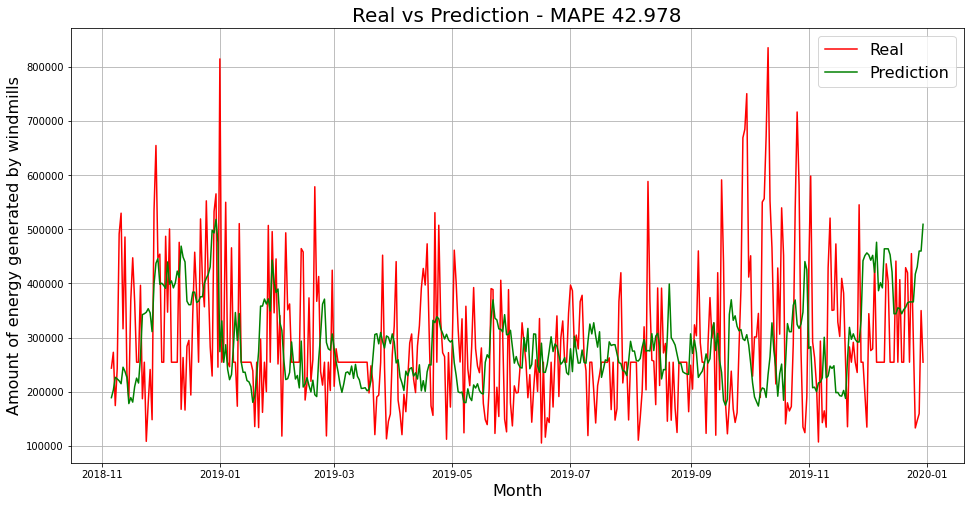

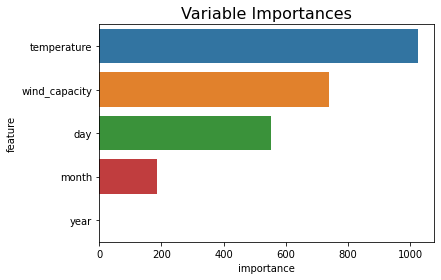

In [340]:
train_time_series_with_folds(gwind)

### With Lags

In [341]:
#create 2 months lag variable by shifting the target value for 1 week
gwind['count_prev_two_months_same_day'] = gwind['wind_generation_actual'].shift(7*60)

#drop NaNs after feature engineering
gwind.dropna(how='any', axis=0, inplace=True)

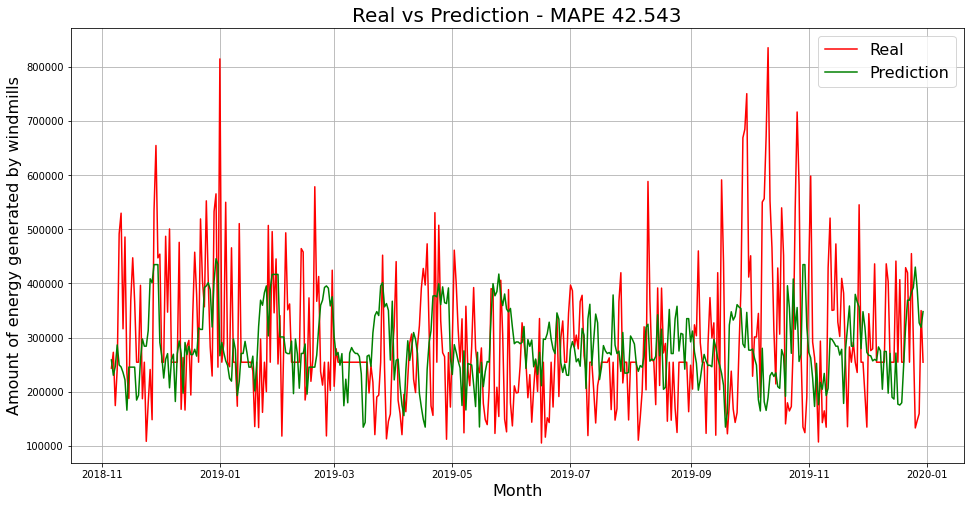

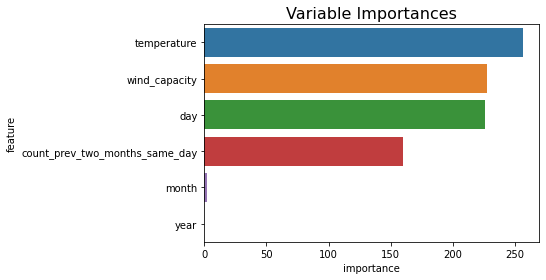

In [342]:
train_time_series_with_folds(gwind)